In [1]:
import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

In [2]:
current_file_dir = os.getcwd()


In [27]:
train_results_json="../out_evaluate_patch_2/train_scores_224_focal.json"
val_results_json="../out_evaluate_patch_2/val_scores_224_focal.json"
train_results_json=os.path.join(current_file_dir,train_results_json)    
val_results_json=os.path.join(current_file_dir,val_results_json)    




def create_view_tables(train_data,clases):
    labels=[]
    preds=[]
    filenames=[]
    for d in train_data:

        filename=d['filename'].replace(".npz",".json")
        scores=d['probs_vistas']
        kk=os.path.join("..",filename)
        if not os.path.exists(kk):
            print(" does not exist: ",kk)
            continue
        with open(kk, "r") as f:
            anot_dict = json.load(f)
            
        truth_vistas=anot_dict['views_annotations']
        
        nvistas=len(truth_vistas)
        nclases=len(clases)
        truths=[]
        
        for n in range(nvistas):
            keyid="view_"+str(n)
            truths.append(truth_vistas[keyid])
        gt=torch.zeros((nvistas,nclases))    
        
        
        # truths: lista de vistas. Cada una de ellas es un diccionario con el nombre del defecto como clave
        for n in range(nvistas):
            for m, defecto in enumerate(clases):
                if defecto in truths[n]:
                    gt[n,m]=float(truths[n][defecto])
                    
        preds1=torch.zeros((nvistas,nclases))
        for n in range(nvistas):
            for m, defecto in enumerate(clases):
                if defecto in scores:
                    preds1[n,m]=float(scores[defecto][n])
        print(gt.shape,preds1.shape)
        labels.append(gt)
        preds.append(preds1)
        filenames.append(filename)
            
    labels=torch.concat(labels,axis=0)
    preds=torch.concat(preds,axis=0)

    return preds,labels,filenames



with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)    

train_data=train_dict['train_results']
val_data = val_dict['val_results']
clases=list(train_dict['train_results'][0]['ground_truth'].keys())

print(len(train_data))
print(len(val_data))

1052
279


In [29]:
preds_train,labels_train,filenames_train=create_view_tables(train_data,clases)
preds_val,labels_val,filenames_val=create_view_tables(val_data,clases)
print(len(filenames_train))
print(preds_train.shape,labels_train.shape)

torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([8, 9]) torch.Size([8, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.Size([11, 9])
torch.Size([11, 9]) torch.

# Cantidad de Vistas de con cada defecto

In [30]:
print("==========================================")
print("  ** VAL **")
print("==========================================")

n_por_defecto=labels_val.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_val.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_val.shape[0])

print("\n==========================================")
print("  ** TRAIN **")
print("==========================================")

n_por_defecto=labels_train.sum(dim=0)
for k in range(len(clases)):
    print(f'{clases[k]} : {int(n_por_defecto[k].item())}')

k=labels_train.sum(dim=1)

nbuenos=torch.sum(k==0)
print("N sin defectos:",nbuenos.item())
print("N total:",labels_train.shape[0])

  ** VAL **
green : 67
hollow : 70
light_scars : 101
oil_spots : 64
plu_stickers : 40
rotten : 138
scars : 68
skin_breakdown : 43
surface : 758
N sin defectos: 1330
N total: 2576

  ** TRAIN **
green : 535
hollow : 295
light_scars : 350
oil_spots : 215
plu_stickers : 106
rotten : 868
scars : 309
skin_breakdown : 298
surface : 2747
N sin defectos: 4794
N total: 10042


# Análisis AUROC por categorías por vistas

In [31]:
f_auroc=AUROC(task='multilabel',num_labels=len(clases),average='none')
res=f_auroc(preds_val,labels_val.int())
res=res.tolist()

aucs={}
for c,auc in zip(clases,res):
    aucs[c]=auc
    print(f'AUC-val({c}) : {auc:.3f}')


AUC-val(green) : 0.977
AUC-val(hollow) : 0.946
AUC-val(light_scars) : 0.909
AUC-val(oil_spots) : 0.984
AUC-val(plu_stickers) : 0.999
AUC-val(rotten) : 0.917
AUC-val(scars) : 0.977
AUC-val(skin_breakdown) : 0.942
AUC-val(surface) : 0.935


# Histogramas de probabilidades por clase

## Validación

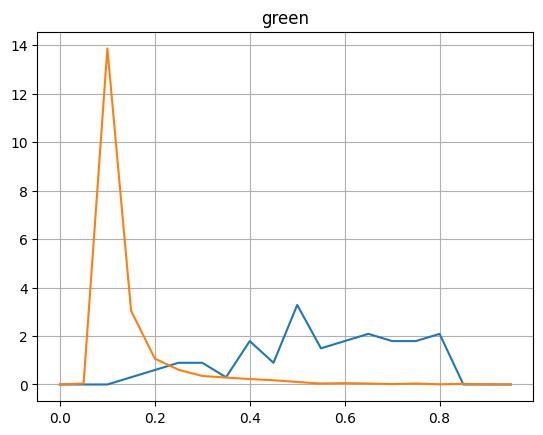

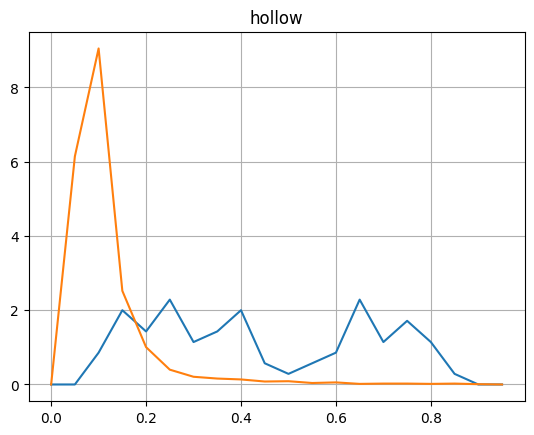

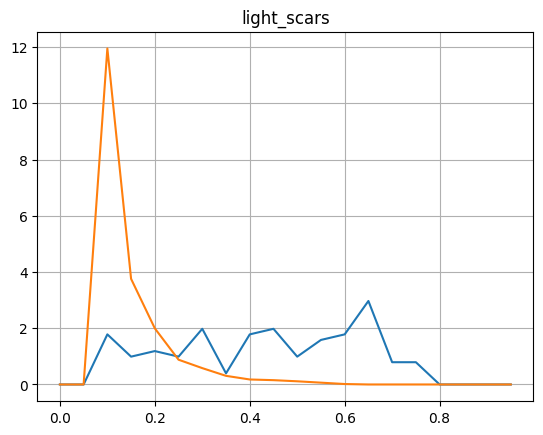

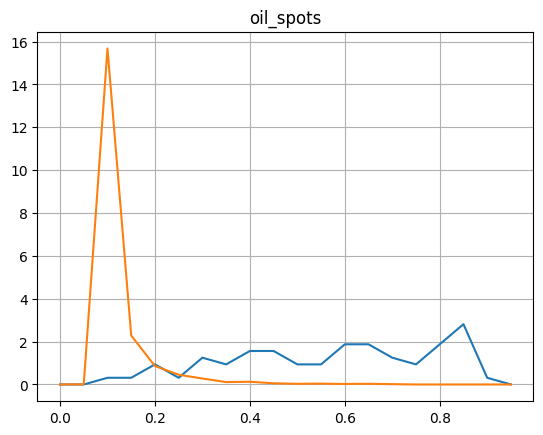

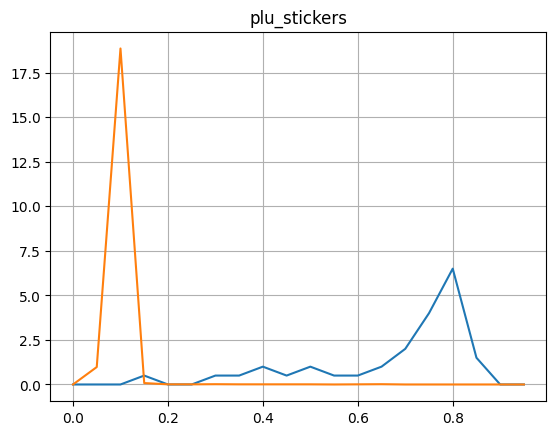

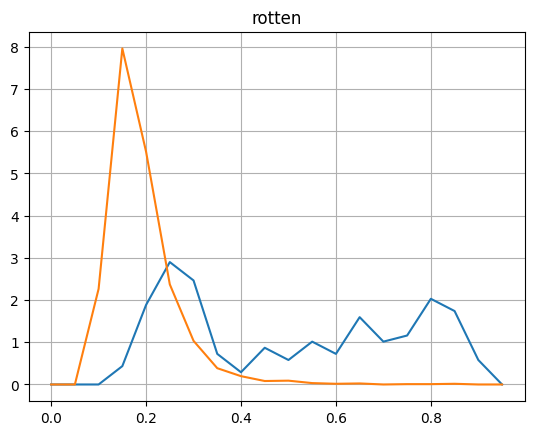

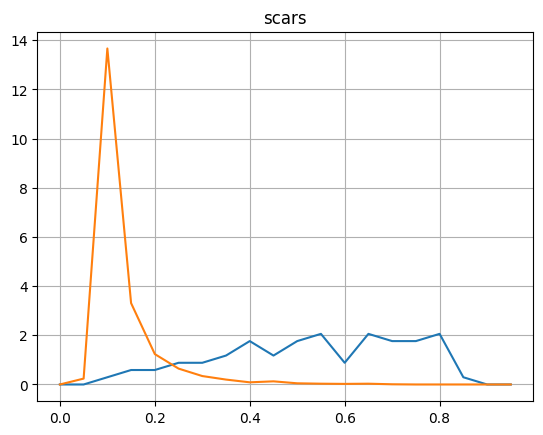

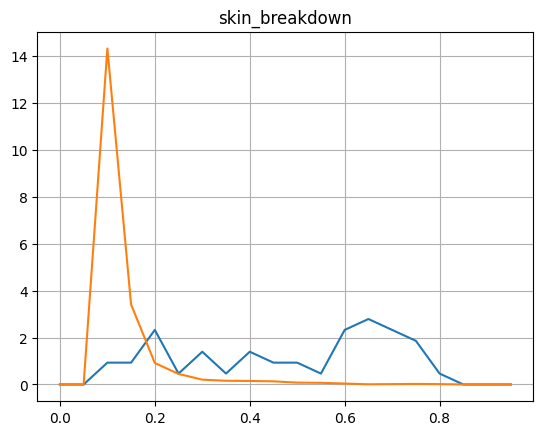

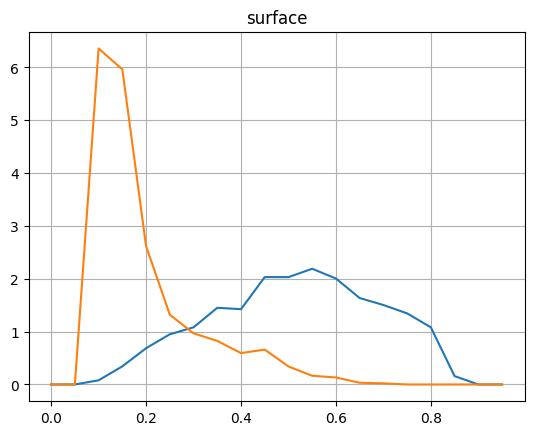

In [32]:
for id_clase in range(len(clases)):
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]

    target_pos=t[t>0.5]
    pred_pos=prob[t>0.5]

    target_neg=t[t<0.5]
    pred_neg=prob[t<0.5]

    
    hh=np.ones(1)/1
    hpos,e=np.histogram(pred_pos,bins=20,range=(0.0,1.0),density=True)
    hneg,f=np.histogram(pred_neg,bins=20,range=(0.0,1.0),density=True)
    
    hpos=np.convolve(hpos, hh, 'same')
    hneg=np.convolve(hneg, hh, 'same')
    _=plt.figure()
    _=plt.plot(e[:-1],hpos)
    _=plt.plot(f[:-1],hneg)
    _=plt.title(clases[id_clase])
    _=plt.grid()

# Probabilidades acumuladas

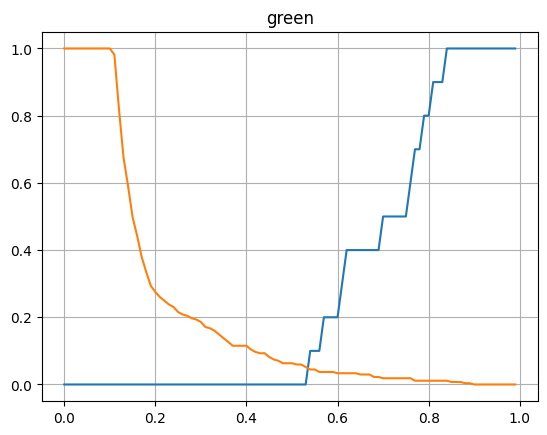

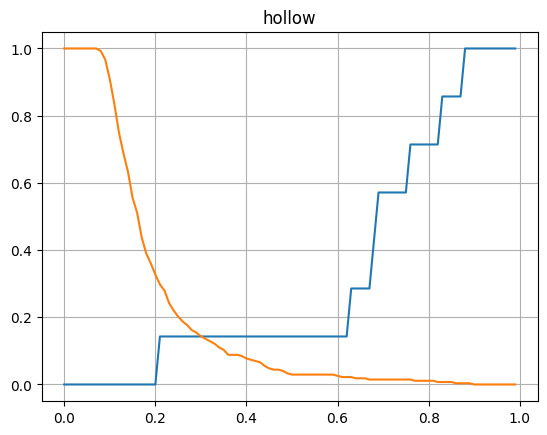

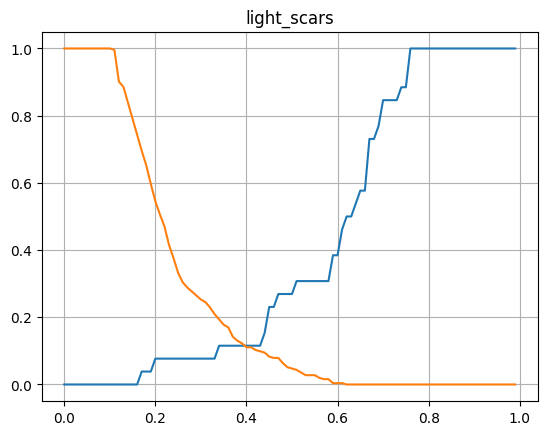

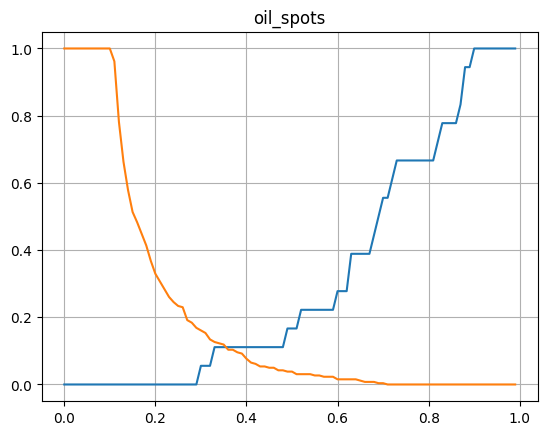

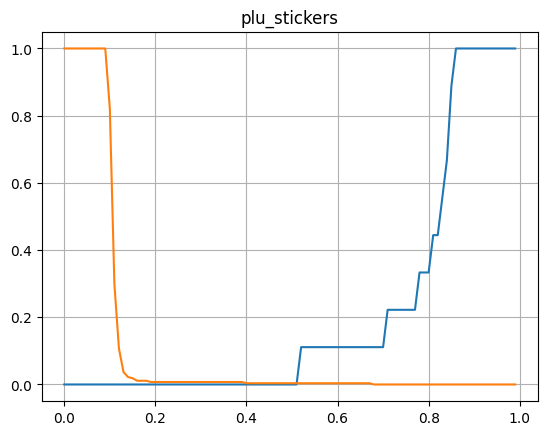

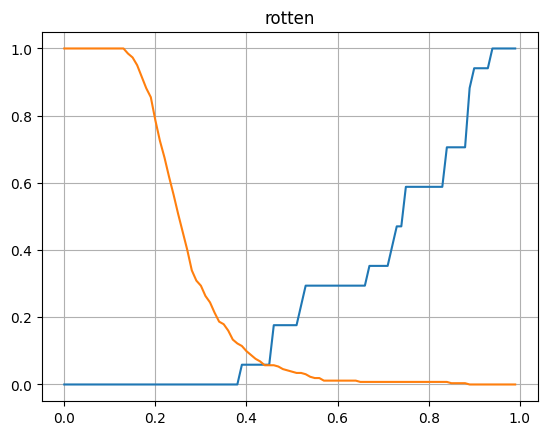

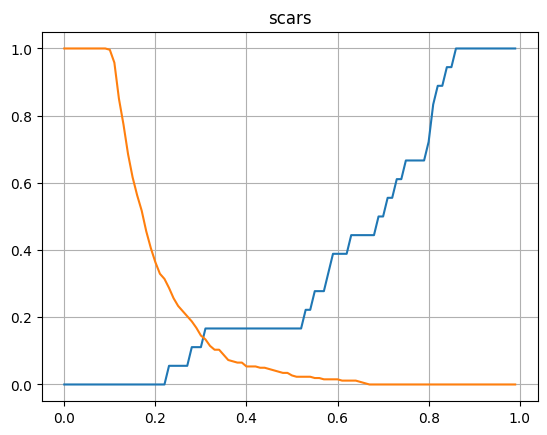

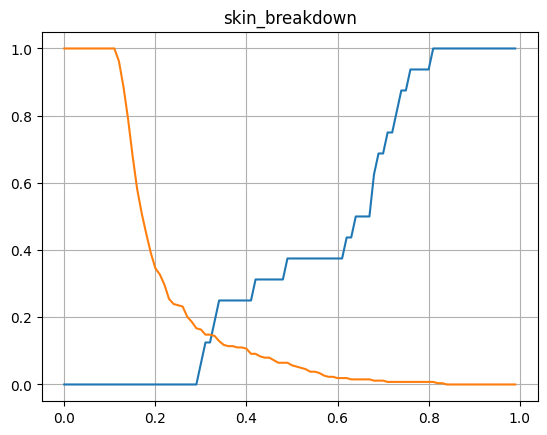

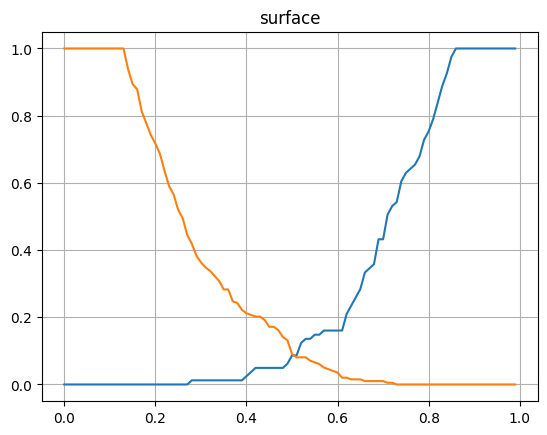

In [8]:
for id_clase in range(len(clases)):
    prob=preds_val[:,id_clase]
    t=labels_val[:,id_clase]

    target_pos=t[t>0.5]
    pred_pos=prob[t>0.5]

    target_neg=t[t<0.5]
    pred_neg=prob[t<0.5]

    
    hh=np.ones(1)/1
    hpos,e=np.histogram(pred_pos,bins=100,range=(0.0,1.0),density=True)
    hneg,f=np.histogram(pred_neg,bins=100,range=(0.0,1.0),density=True)

    hpos /= hpos.sum()
    hneg /= hneg.sum()
    
    hposcum=np.cumsum(hpos)
    hnegcum=1-np.cumsum(hneg)
    _=plt.figure()
    _=plt.plot(e[:-1],hposcum)
    _=plt.plot(f[:-1],hnegcum)
    _=plt.title(clases[id_clase])
    _=plt.grid()

# Casos con más error de validación